## Install Detectron2

In [1]:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# %%capture
!pip install pyyaml==5.1
!pip uninstall --yes torch
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=7ffc17f21e1e401b743d3996da2bf5f8fec74c163bc53dd4e4262f77a4050003
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Found existing installation: torch 1.9.0+cu102
Uninstalling torch-1.9.0+cu102:
  Successfully uninstalled torch-1.9.0+cu102
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 14 kB/s 
     |████████████████████████████████| 17.3 MB 257 kB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [2]:
!unzip -qq /content/drive/MyDrive/Hateful_Memes/hateful_memes.zip

In [3]:

# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [4]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
import os

In [5]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

## Get our data

In [6]:
import pandas as pd
df_train = pd.read_json('hateful_memes/train.jsonl', lines=True)
df_train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [7]:
df_val = pd.read_json('hateful_memes/dev_seen.jsonl', lines=True)
df_val.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [8]:
df_train.shape, df_val.shape

((8500, 4), (500, 4))

(400, 250, 3)


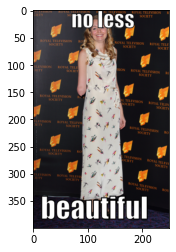

In [9]:
## Read img by ID
idx = 2139
image_id = str(idx).zfill(5)
img2 = plt.imread(f'hateful_memes/img/{image_id}.png')
print(img2.shape)

# Detectron expects BGR images
img_bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img2)
plt.show()

In [10]:
print(df_train[df_train['id'] == idx]['text'])

319    no less beautiful
Name: text, dtype: object


### Load Config and Model Weights

I am using the MaskRCNN ResNet-101 FPN checkpoint, but you can use any checkpoint of your preference. This checkpoint is pre-trained on the COCO dataset. You can check other checkpoints/configs on the Model Zoo page.

In [11]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

### Load the Object Detection Model
The `build_model` method can be used to load a model from the configuration, the checkpoints have to be loaded using the `DetetionCheckpointer`.

In [12]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)
model = model.to('cuda')

model_final_a3ec72.pkl: 254MB [00:25, 10.0MB/s]                           
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


### Convert Image to Model Input
The detectron uses resizing and normalization based on the configuration parameters and the input is to be provided using `ImageList`. The `model.backbone.size_divisibility` handles the sizes (padding) such that the FPN lateral and output convolutional features have same dimensions.

In [13]:
def create_image_list(img_path):
    img_dict = {}
    img_list = []
    for img_file in sorted(os.listdir(img_path)):
        img_id = img_file.split('/')[-1].split('.')[0]
        img = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
        img_dict[img_id] = img
        img_list.append(img)
    return img_dict, img_list

# img_dict, img_list = create_image_list('hateful_memes/img')

In [14]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1)).to('cuda')

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1).to('cuda')
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1).to('cuda')
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

images, batched_inputs = prepare_image_inputs(cfg, [img_bgr2, img_bgr2])

### Get ResNet+FPN features
The ResNet model in combination with FPN generates five features for an image at different levels of complexity. For more details, refer to the FPN paper or this [article](https://medium.com/@hirotoschwert/digging-into-detectron-2-47b2e794fabd). For this tutorial, just know that `p2`, `p3`, `p4`, `p5`, `p6` are the features needed by the RPN (Region Proposal Network). The proposals in combination with `p2`, `p3`, `p4`, `p5` are then used by the ROI (Region of Interest) heads to generate box predictions.

In [15]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

features = get_features(model, images)

In [16]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

In [17]:
features['p2'].shape

torch.Size([2, 256, 320, 200])

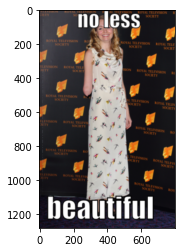

torch.Size([2, 256, 320, 200])


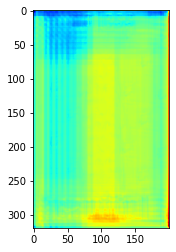

torch.Size([2, 256, 160, 100])


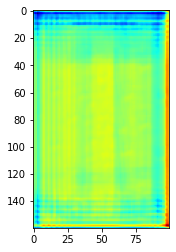

torch.Size([2, 256, 80, 50])


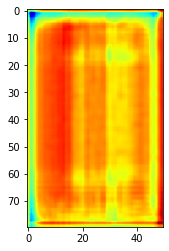

torch.Size([2, 256, 40, 25])


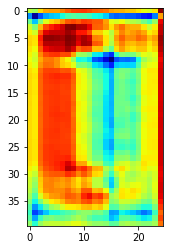

torch.Size([2, 256, 20, 13])


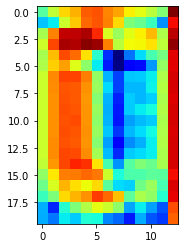

In [18]:
plt.imshow(cv2.resize(img2, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][0,0,:,:].cpu().squeeze().detach().numpy(), cmap='jet')
    plt.show()

### Get region proposals from RPN
This RPN takes in the features and images and generates the proposals. Based on the configuration we chose, we get 1000 proposals.

In [19]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(model, images, features)

## Get Box Features for the proposals
The proposals and features are then used by the ROI heads to get the predictions. In this case, the partial execution of layers becomes significant. We want the box_features to be the fc2 outputs of the regions. Hence, I use only the layers that are needed until that step.

In [20]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)
    batch_size =2
    embed_size = 1024
    box_features = box_features.reshape(batch_size, -1, embed_size) # depends on your config and batch size
    return box_features, features_list

box_features, features_list = get_box_features(model, features, proposals)

### Get prediction logits and boxes
The prediction class logits and the box predictions from the ROI heads, this is used in the next step to get the boxes and scores from the `FastRCNNOutputs`

In [21]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

### Get FastRCNN scores and boxes

This results in the softmax scores and the boxes.

In [22]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

## Scale
Scale boxes to the size of the image

In [23]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4)
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:284: UserWarning: Output 0 of SliceBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
  self.tensor[:, 0::2] *= scale_x
/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:285: UserWarning: Output 0 of SliceBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pyt

In [24]:
print(output_boxes)

[Boxes(tensor([[  34.0190,   12.7376,  790.2778, 1006.0250],
        [  24.7744,    0.0000,  785.6715, 1002.9683],
        [   0.0000,    0.0000,  800.0000, 1006.7823],
        ...,
        [ 798.0150,  991.6024,  800.0000, 1006.6534],
        [ 797.9943,  991.2296,  799.9973, 1006.9062],
        [ 798.0125,  991.6911,  800.0000, 1006.5228]], device='cuda:0',
       grad_fn=<StackBackward>)), Boxes(tensor([[  34.0190,   12.7376,  790.2778, 1006.0250],
        [  24.7744,    0.0000,  785.6715, 1002.9683],
        [   0.0000,    0.0000,  800.0000, 1006.7823],
        ...,
        [ 798.0150,  991.6024,  800.0000, 1006.6534],
        [ 797.9943,  991.2296,  799.9973, 1006.9062],
        [ 798.0125,  991.6911,  800.0000, 1006.5228]], device='cuda:0',
       grad_fn=<StackBackward>))]


### Select the Boxes using NMS
We need two thresholds - NMS threshold for the NMS box section, and score threshold for the score based section.

First NMS is performed for all the classes and the max scores of each proposal box and each class is updated.

Then the class score threshold is used to select the boxes from those.

In [25]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0])).to('cuda')
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = nms(det_boxes, cls_scores, test_nms_thresh)
        # keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh).cpu())
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [26]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

### Limit the total number of boxes
In order to get the box features for the best few proposals and limit the sequence length, we set minimum and maximum boxes and pick those box features

In [27]:
keep_boxes

[tensor([ 11,  28,  35,  48,  49,  56,  60,  72,  73,  79,  80,  89,  90,  96,
          99, 107, 110, 116, 118, 120, 121, 126, 127, 135, 140, 141, 145, 147,
         152, 153, 157, 163, 165, 167, 169, 170, 176, 182, 186, 192, 195, 196,
         200, 204, 219, 220, 226, 228, 230, 231, 233, 234, 235, 236, 237, 246,
         248, 249, 251, 254, 257, 261, 267, 271, 274, 275, 276, 277, 278, 279,
         281, 282, 288, 296, 297, 299, 300, 307, 308, 312, 313, 314, 315, 319,
         321, 339, 342, 352, 354, 355, 356, 357, 360, 361, 363, 364, 366, 369,
         373, 374, 379, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 397,
         398, 400, 401, 402, 407, 418, 420, 421, 423, 425, 426, 432, 433, 437,
         438, 440, 442, 446, 450, 455, 456, 459, 461, 467, 470, 471, 473, 475,
         479, 481, 482, 484, 486, 488, 489, 491, 494, 498, 501, 502, 506, 514,
         516, 517, 519, 523, 524, 526, 527, 528, 531, 533, 536, 540, 543, 545,
         547, 551, 552, 559, 560, 567, 569, 578, 580

In [28]:
max_conf[1].shape, keep_boxes[1].shape

(torch.Size([1000]), torch.Size([381]))

In [29]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    keep_boxes = keep_boxes.tolist()
    if len(keep_boxes) < min_boxes:
        keep_boxes = torch.argsort(max_conf, dim=-1, descending=True)[:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = torch.argsort(max_conf, dim=-1, descending=True)[:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

In [30]:
print(keep_boxes)

[tensor([527, 361, 360, 356, 366, 339, 321, 308, 363, 432, 389, 391, 275, 710,
        617, 237, 228, 611, 569, 921, 801, 397, 440, 374, 486, 381, 364, 442,
        655, 516, 231, 494, 271, 560, 526, 545, 737, 620, 624, 456, 547, 809,
        938, 968, 945, 928, 955, 944, 589, 709, 708, 729, 567, 615, 608, 619,
        733, 828, 818, 803, 594, 829, 369, 722, 230, 249, 528, 467, 354, 891,
        355, 488, 776, 747, 484, 392, 186, 246, 470, 278, 455, 461, 726, 862,
        459, 296, 118, 279, 540, 750, 342, 281, 559, 274, 425, 523, 307, 165,
        300, 552], device='cuda:0'), tensor([527, 361, 360, 356, 366, 339, 321, 308, 363, 432, 389, 391, 275, 710,
        617, 237, 228, 611, 569, 921, 801, 397, 440, 374, 486, 381, 364, 442,
        655, 516, 231, 494, 271, 560, 526, 545, 737, 620, 624, 456, 547, 809,
        938, 968, 945, 928, 955, 944, 589, 709, 708, 729, 567, 615, 608, 619,
        733, 828, 818, 803, 594, 829, 369, 722, 230, 249, 528, 467, 354, 891,
        355, 488, 776, 747

### Get the visual embeddings :) 
Finally, the boxes are chosen using the `keep_boxes` indices and from the `box_features` tensor.

In [31]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [32]:
print(visual_embeds[1])

tensor([[-2.1243, -1.1640,  0.3660,  ..., -1.4735,  0.0277,  0.0483],
        [-1.4813, -1.3356,  0.4337,  ..., -1.0201,  0.6654,  0.3161],
        [-1.4885, -1.3392,  0.4368,  ..., -1.0193,  0.6685,  0.3138],
        ...,
        [-0.4201, -0.7561, -0.2984,  ..., -1.7439, -0.6780,  0.0601],
        [ 0.1976, -1.3968, -0.5996,  ..., -1.6209,  0.0830,  0.7162],
        [ 0.6067, -0.3540,  1.2379,  ..., -0.4087,  0.4993,  0.6308]],
       device='cuda:0', grad_fn=<IndexBackward>)


# Run this as a pipeline

In [33]:
!nvidia-smi

Fri Jul 23 18:59:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    41W / 250W |   3665MiB / 16280MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

import pickle
with open('/content/drive/MyDrive/Hateful_Memes/features1.pickle', 'rb') as handle:
    b = pickle.load(handle)
ids_done = b.keys()
print(len(ids_done))

In [34]:
model = model.to('cuda')

In [35]:
df_train['row_id'] = df_train.index
df_train.head()

,id,img,label,text,row_id
0,42953,img/42953.png,0,its their character not their color that matters,0
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,1
2,13894,img/13894.png,0,putting bows on your pet,2
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,3
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",4


In [36]:
imgs = df_train['img'].tolist()
print(imgs[:5])

['img/42953.png', 'img/23058.png', 'img/13894.png', 'img/37408.png', 'img/82403.png']


In [37]:
import pickle

In [38]:
def generate_visual_embeddings(df, filename):
    features_dict = {}
    exceptions = []
    MIN_BOXES=10
    MAX_BOXES=100
    cnt = 0
    all_files = df['img'].tolist()
    img_ids = df['id'].tolist()
    print("Num total files: ", len(all_files))
    handle = open(filename, 'wb')
    for i in range(0, len(all_files), 2):
        if cnt%1000 == 0:
            print("Finished: ", cnt)
        ## Get image
        try:
            img1 = cv2.imread(os.path.join('hateful_memes', all_files[i]))
            img2 = cv2.imread(os.path.join('hateful_memes', all_files[i+1]))
            img_id1 = img_ids[i]
            img_id2 = img_ids[i+1]
            # print(img_id1, img_id2, img1.shape, img2.shape)
            ## Prepare in proper format
            images, batched_inputs = prepare_image_inputs(cfg, [img1, img2])
            ## Generate features
            features = get_features(model, images)
            ## Get proposals from RPN
            proposals = get_proposals(model, images, features)
            ## Get box features from proposals
            box_features, features_list = get_box_features(model, features, proposals)
            ## Get prediction logits and boxes
            pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)
            ## Get Faster RCNN scores and boxes
            boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)
            ## Scale boxes to original image size
            output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]
            ## Select boxes using NMS
            temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
            keep_boxes, max_conf = [],[]
            for keep_box, mx_conf in temp:
                keep_boxes.append(keep_box)
                max_conf.append(mx_conf)

            ## Limit total number of boxes
            keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
            ### Generate visual embeddings
            visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
            # arr[row_id1] = visual_embeds[0].detach().cpu().numpy()
            # arr[row_id2] = visual_embeds[1].detach().cpu().numpy()
            features_dict[img_id1] = visual_embeds[0].detach().cpu().numpy()
            features_dict[img_id2] = visual_embeds[1].detach().cpu().numpy()
            cnt += 1
            with open(filename, 'wb') as handle:
                pickle.dump(features_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except:
            print("Error processing id: ", img_id1, img_id1)
            exceptions.append(img_id1)
            exceptions.append(img_id2)

In [ ]:
generate_visual_embeddings(df_train, '/content/drive/MyDrive/Hateful_Memes/features_train.pickle')

Num total files:  8500
Finished:  0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:284: UserWarning: Output 0 of SliceBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
  self.tensor[:, 0::2] *= scale_x
/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:285: UserWarning: Output 0 of SliceBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pyt

Error processing id:  18257 18257
Finished:  1000
Error processing id:  10357 10357
Finished:  2000
Finished:  3000


In [ ]:
generate_visual_embeddings(df_val, '/content/drive/MyDrive/Hateful_Memes/features_val.pickle')

from google.colab import files
files.download('features.pickle') 